In [508]:
import numpy as np
import pandas as pd
import rebound
import reboundx
import matplotlib.pyplot as plt
import time
import random
seed = 3
random.seed(seed)

# TNOs, Centaurs, and SDOs: https://www.minorplanetcenter.net/iau/MPCORB/Distant.txt
# TNOs only: https://minorplanetcenter.net/iau/lists/TNOs.html

# cat TNOs.txt | cut -c 93- | cut -c -16 > lite_TNOs.txt for inc, e, and a only
# cat TNOs.txt | cut -c 73- | cut -c -36 > lite_TNOs.txt for all six orbital elements
tnos = pd.read_csv('lite_TNOs.txt',delim_whitespace=True)
tnos.head()

,M,Peri.,Node,Incl.,e,a
0,249.1,215.8,218.5,13.7,0.209,39.5
1,202.0,318.7,31.1,8.2,0.233,46.7
2,239.7,218.0,124.0,15.2,0.148,47.9
3,6.0,135.4,353.2,15.2,0.224,47.7
4,28.9,44.8,58.3,10.2,0.078,44.4


In [509]:
# convert from a to P and P to a with Newtonian version of Kepler's 3rd Law
def a_to_P(a,G,mA,mB):
    return ((a**3)*4*((np.pi)**2)/(G*(mA+mB)))**(1./2)

Planetisimals influence planets but not each other. Planetisimals colliding with a planet merge mass and momentum with it. Track energy lost through collisions and ejections. Remove particles that exit our pre-defined box.

In [510]:
sim = rebound.Simulation()

#integrator options
sim.integrator = "mercurius"
sim.dt = 100 * 2 * np.pi # we're working in units where 1 year = 2*pi
sim.testparticle_type = 1
sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration

#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.track_energy_offset = 1

In [511]:
# add only active particles
sim.add(m=1.)
sim.add(m=9.547919e-4, r=1.0049e-1, a=5.2044, e=4.89e-2,f=2*np.pi*random.random()) # add Jupiter
sim.add(m=2.857e-4, r=8.3703e-2, a=9.5826, e=5.65e-2,f=2*np.pi*random.random()) # add Saturn
sim.add(m=4.365e-5, r=3.6455e-2, a=19.2184, e=4.6381e-2,f=2*np.pi*random.random()) # add Uranus
sim.add(m=5.149e-5, r=3.5392e-2, a=30.11, e=9.456e-3,f=2*np.pi*random.random()) # add Neptune
sim.N_active = sim.N   # sim.N=5

In [512]:
# add semi-active particles, ie. TNOs
for row in range(len(tnos) - 1000):
    # set orbital parameters
    M = tnos.iloc()[row][0]*np.pi/180 # mean anomaly...without the epoch?
    omega = tnos.iloc()[row][1]*np.pi/180 # arg of pericenter/perihelion
    Omega = tnos.iloc()[row][2]*np.pi/180 # longitude of ascending node
    inc = tnos.iloc()[row][3]*np.pi/180 
    e = tnos.iloc()[row][4]
    a = tnos.iloc()[row][5]
    
    # add object
    sim.add(inc=inc,e=e,a=a,omega=omega,Omega=Omega,M=M,r=random.random()*1e-4)

ps = sim.particles

In [513]:
# add radiation forces with ReboundX
rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces") # set forces
rebx.add_force(rf)
rf.params["c"] = 3.e8 # set forces to speed of light
ps[0].params["radiation_source"] = 1 # reindex radiation source from 0 vector to first particle
beta = 0.1 # set ratio of radiation force to gravitational force

# add mass loss with ReboundX...unfortunately not with Mercurius anymore
#mm = rebx.load_operator("modify_mass")
#rebx.add_operator(mm)

In [514]:
sim.move_to_com()
E0 = sim.calculate_energy()
print(E0)

-0.00010864294039


Text(0.5,1,u'Edge-on view')

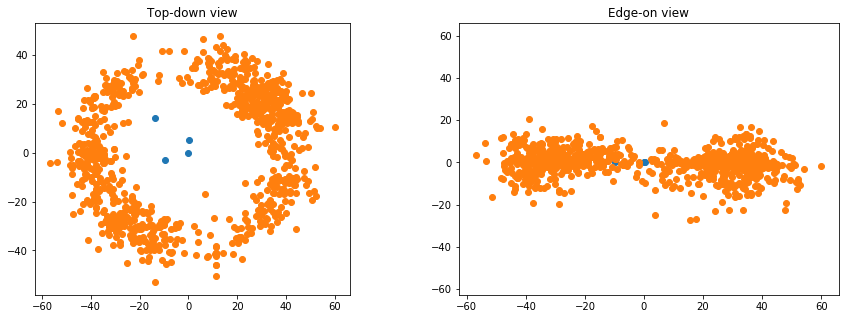

In [515]:
# plot initialized objects
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(xs[0:4], ys[0:4])
ax1.scatter(xs[5:], ys[5:])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(xs[0:4], zs[0:4])
ax2.scatter(xs[5:], zs[5:])
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

In [516]:
start = time.clock()
# simulate system for 100 Myears
Noutputs = int(1e5)
sim_length = 1e8 * 2 * np.pi
times = np.linspace(0.,sim_length,Noutputs)
encounterN = np.zeros(len(times))
totalN = np.zeros(len(times))
errors = np.zeros(len(times))
mass = np.zeros(len(times))
for i,t in enumerate(times):
    sim.integrate(t,exact_finish_time=0)
    totalN[i] = sim.N 
    encounterN[i] = sim.ri_mercurius._encounterN # particle coming within 3 Hill radii of a planet
    errors[i] = abs((sim.calculate_energy() - E0)/E0)
    mass[i] = ps[0].m

end = time.clock()
print (end-start)

4115.243164


In [517]:
E1 = sim.calculate_energy()
print(E1)
print(E1-E0)

1.10663257639e-05
0.000119709266154


Text(0.5,1,u'Edge-on view')

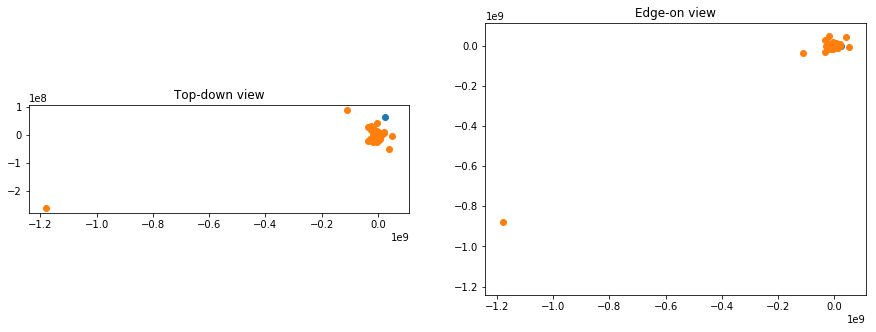

In [518]:
# plot initialized objects
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(xs[0:4], ys[0:4])
ax1.scatter(xs[5:], ys[5:])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(xs[0:4], zs[0:4])
ax2.scatter(xs[5:], zs[5:])
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

(-75000000.0, 75000000.0)

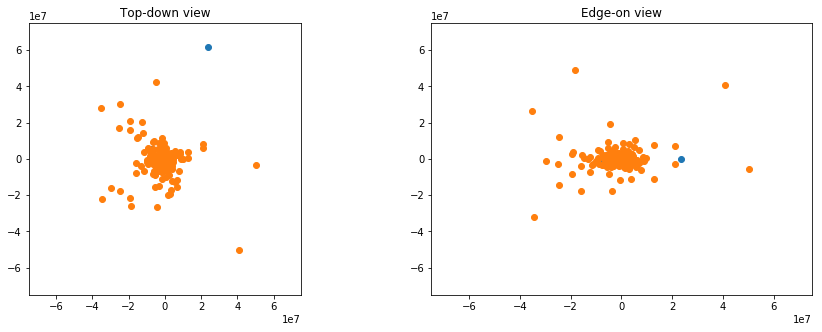

In [531]:
# plot initialized objects
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(xs[0:4], ys[0:4])
ax1.scatter(xs[5:], ys[5:])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
#ax1.set_xlim((-0.75e8,0.75e8))
#ax1.set_ylim((-0.75e8,0.75e8))
ax2.scatter(xs[0:4], zs[0:4])
ax2.scatter(xs[5:], zs[5:])
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')
#ax2.set_xlim((-0.75e8,0.75e8))
#ax2.set_ylim((-0.75e8,0.75e8))

(-10000000.0, 10000000.0)

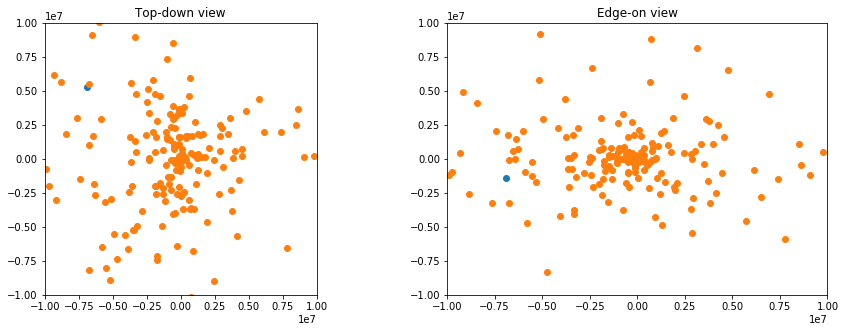

In [529]:
# plot initialized objects
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(xs[0:4], ys[0:4])
ax1.scatter(xs[5:], ys[5:])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
#ax1.set_xlim((-1e7,1e7))
#ax1.set_ylim((-1e7,1e7))
ax2.scatter(xs[0:4], zs[0:4])
ax2.scatter(xs[5:], zs[5:])
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')
#ax2.set_xlim((-1e7,1e7))
#ax2.set_ylim((-1e7,1e7))

In [532]:
print(ps[0])
print(ps[1])
print(ps[2])
print(ps[3])
print(ps[4])

<rebound.Particle object, m=0.533487985785 x=-59111.7811541 y=-154225.714397 z=0.0 vx=-9.41714385272e-05 vy=-0.000245698464479 vz=0.0>
<rebound.Particle object, m=0.0013356319 x=23610865.4368 y=61601977.109 z=0.0 vx=0.0376146534523 vy=0.0981387004348 vz=0.0>
<rebound.Particle object, m=0.0 x=-59141.2371848 y=-154267.131108 z=16.4069334146 vx=0.07164151747 vy=-0.0674965402884 vz=-0.0149037762257>
<rebound.Particle object, m=0.0 x=-6901091.95664 y=5282112.10834 z=-1395689.75022 vx=-0.0134755189926 vy=0.0103859491097 vz=-0.0027297314888>
<rebound.Particle object, m=0.0 x=-59128.9892337 y=-154249.728021 z=95.6440886743 vx=-0.00403712857569 vy=-0.0514755567961 vz=-0.0467126292507>


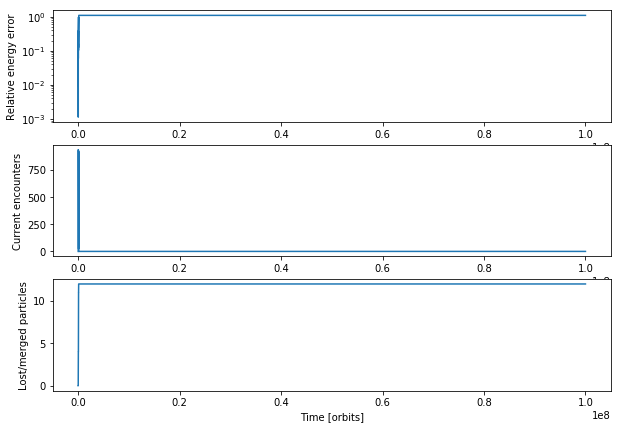

In [533]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(311)
plt.yscale("log")
plt.plot(times/(2.*np.pi), errors);
ax.set_ylabel("Relative energy error")
ax = plt.subplot(312)
ax.set_ylabel("Current encounters")
plt.plot(times/(2.*np.pi), encounterN);
ax = plt.subplot(313)
ax.set_ylabel("Lost/merged particles")
ax.set_xlabel("Time [orbits]")
plt.plot(times/(2.*np.pi), -(totalN-(len(tnos)-1000+5)))

In [534]:
sim.N

927

In [535]:
ps[0].m

0.5334879857847492